## Import

In [1]:
from scipy.io import wavfile
from scipy.fftpack import fft
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

%matplotlib inline

## Hangfájl beolvasása

In [2]:
fs, wav = wavfile.read("XC247504-berki_tucsokmadar.wav")
wav

/home/tomi/anaconda3/lib/python3.5/site-packages/scipy/io/wavfile.py:221: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


array([ -57,    5,   72, ...,   53,  -60, -172], dtype=int16)

## Hangcsatornák szétválasztása

In [3]:
stereo = (wav.ndim == 2)
if stereo:
    ch_a = wav[:,0]
    ch_b = wav[:,1]
    ch_avg = np.sum(wav, axis=1)/2
    channels = {"a":ch_a, "b":ch_b, "c":ch_avg}
else:
    channels = {"a":wav, "b":None, "c":None}
channels


{'a': array([ -57,    5,   72, ...,   53,  -60, -172], dtype=int16),
 'b': None,
 'c': None}

In [4]:
t = np.arange(0, channels['a'].size/fs, 1/fs)
if stereo:
    plt.plot(t, channels['a'])

In [5]:
Audio(data=wav, rate=fs)

## Jel kiválasztása FFT-re
 - FFT mérete csak 2 hatványa lehet

In [6]:
fft_samples = 2**9
dt = fft_samples / fs
df = 1.0/dt
start = 180000
y = channels['a'][start:start+fft_samples]
x = np.arange(0,fft_samples,1)
plt.plot(x,y)

## Jel szorzása Hamming ablakkal
  - ez egy frekvenciaszűrés az időtartományban

In [7]:
window = scipy.signal.hamming(fft_samples)
y = window*y
plt.plot(x,y)

## Fast Fourier Transform

In [8]:
yf = fft(y)
yf = abs(yf)
yf = yf / max(yf)
xf = np.arange(0,fft_samples,1)
plt.plot(xf[0:int(fft_samples/2)],np.abs(yf[0:int(fft_samples/2)]))

## PEAKS?

In [9]:
# http://stackoverflow.com/questions/31016267/peak-detection-in-python-how-does-the-scipy-signal-find-peaks-cwt-function-work
# https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
# The Scipy find_peaks_cwt will really prove useful in presence of noisy data, as it uses continuous wavelet transform.
indexes = scipy.signal.find_peaks_cwt(xf, np.arange(1,10))
indexes
# [[x,indexes.count(x)] for x in set(indexes)]

[508]

In [10]:
import peakutils
indexes = peakutils.indexes(yf, thres=0.02/max(xf), min_dist=100)
print(indexes)

[ 56 158 354 456]


In [11]:
from detect_peaks import detect_peaks
indexes = detect_peaks(yf, mph=0.04, mpd=100)
indexes

array([ 56, 456])

# Spektrogram

## jel kiválasztása

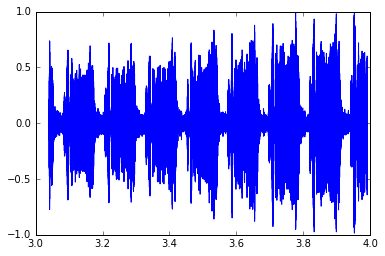

In [12]:
s1 = 134000
s2 = 176000
selection = np.arange(s1,s2,1)
signal = channels['a'][selection]
signal = signal / np.max(signal)
plt.plot(selection/fs, signal)
Audio(data=signal, rate=fs)

## gördülő ablak beállítása

In [13]:
shift = int(fft_samples/2)
count = int((signal.size-fft_samples)/shift + 1)
spectrogram = np.ndarray(shape=(count,256))

## FFT számolása a kijelölésen (ablakonként)

In [14]:
for slide in range(count):
    x = signal[slide*shift:slide*shift+fft_samples]
    f = fft(window*x)
    spectrogram[slide,0:int(fft_samples/2)] = abs(f[0:int(fft_samples/2)])

## kirajzolás

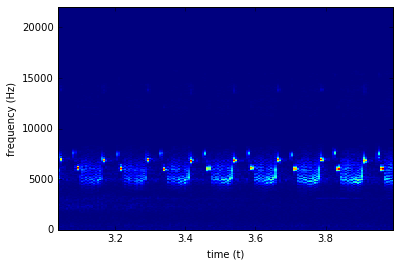

In [15]:
s = spectrogram
f1, f2 = 0, fs/2
t1, t2 = s1/fs, s2/fs
plt.imshow(s.transpose(), origin='lower', cmap='jet', interpolation='nearest', aspect='auto', extent=[t1,t2,f1,f2])
plt.xlabel("time (t)")
plt.ylabel("frequency (Hz)")
# vmin=0, vmax=1,